In [137]:
import torch
import pickle
from helper.model import *
from helper.utils import *
from helper.distance_map import *
from helper.evaluate import *
from scipy import stats
import pandas as pd
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

args_train_data = "uniref100_full"
args_test_data = "price_149"
#args_test_data = "new"
args_model_name = "split100_ensemble/split100_"  
args_weight_path = "uncertainty_ensemble/" 
args_N_models = 8

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype = torch.float32
#
id_ec_train, ec_id_dict_train = get_ec_id_dict('./data/'+args_train_data+'.csv')
id_ec_test, _ = get_ec_id_dict('./data/'+args_test_data+'.csv')

In [35]:
# keep models output embeddings
esm_embedding_train = esm_embedding(ec_id_dict_train, device, dtype)

for i in (range(args_N_models)):
    model_i = LayerNormNet(512, 128, device, dtype)
    model_name_i = args_model_name + str(i)
    print("loading model:", model_name_i)
    checkpoint = torch.load('./model/' + model_name_i + '.pth')
    model_i.load_state_dict(checkpoint)
    model_i.eval()
    emb_train_i = model_i(esm_embedding_train) 
    emb_test_i = model_embedding_test(id_ec_test, model_i, device, dtype) 
    emb_train_i_path = args_weight_path+args_test_data+"_emb_train_"+str(i)+'.pt'
    emb_test_i_path = args_weight_path+args_test_data+"_emb_test_"+str(i)+'.pt'
    torch.save(emb_train_i, emb_train_i_path)
    torch.save(emb_test_i, emb_test_i_path)

In [138]:
# get distance map for all models
eval_dist_df_lst = []
for i in (range(args_N_models)):
    emb_train_i_path = args_weight_path+args_test_data+"_emb_train_"+str(i)+'.pt'
    emb_test_i_path = args_weight_path+args_test_data+"_emb_test_"+str(i)+'.pt'
    emb_train = torch.load(emb_train_i_path)
    emb_test = torch.load(emb_test_i_path)
    eval_dist = get_dist_map_test(
            emb_train, emb_test, ec_id_dict_train, id_ec_test, 
            device, dtype, dot=False)
    eval_dist_df_lst.append(pd.DataFrame.from_dict(eval_dist))


149it [00:00, 973.86it/s]


In [161]:
# get max sep prediction results for all models
all_eval_results = []
for i in (range(args_N_models)):
    df = eval_dist_df_lst[i]; first_grad=True; use_max_grad=False
    query_prediction_lst = []
    for col in df.columns:
        smallest_10_dist_df = df[col].nsmallest(10)
        dist_lst = list(smallest_10_dist_df)
        max_sep_i = maximum_separation(dist_lst, first_grad, use_max_grad)
        predictions = []
        for i in range(max_sep_i+1):
            EC_i = smallest_10_dist_df.index[i]
            dist_i = smallest_10_dist_df[i]
            predictions.append((EC_i, dist_i))
        query_name = col
        query_prediction_lst.append((query_name, predictions))
    all_eval_results.append(query_prediction_lst)

In [140]:
# clean all the predictions results, to have the following format:
# (query_name, predictions), where predictions is
# {ec_0: [distance_0, distance_1, distance_2,...], ...}
all_eval_results_cleaned = []
for query_i in range(len(all_eval_results[0])):
    query_name_i, _ = all_eval_results[0][query_i]
    predictions_query_i = dict()
    for i in (range(args_N_models)):
        _, predictions = all_eval_results[i][query_i]
        for ec, distance in predictions:
            if ec not in predictions_query_i:
                predictions_query_i[ec] = [distance]
            else:
                predictions_query_i[ec].append(distance)
    all_eval_results_cleaned.append((query_name_i, predictions_query_i))   

In [156]:
eval_results_w_std = []
all_prediction_std = [] # record all distances std for ranking
for query_name, predictions in all_eval_results_cleaned:
    # prediction is a dictionary with {ec_i : [distance_i]}
    # pred_mean_std for a query have following format:
    # {ec_i : (mean, std)}
    pred_mean_std = dict()
    for ec_i in predictions:
        dist_i = predictions[ec_i]
        dist_mean = np.mean(dist_i)
        dist_std = np.std(dist_i)
        pred_mean_std[ec_i] = (dist_mean, dist_std)
        all_prediction_std.append(dist_std)
    eval_results_w_std.append((query_name, pred_mean_std))
    # print("=============================")
    # print("distances", query_name, predictions)
    # print("mean/std:", query_name, pred_mean_std)
    #     print(dist_mean, dist_std)
##########################################################################
## swap std with percentile certainty 
## => {ec_i : (mean, percentile_certainty)} 
eval_results_w_certainty = eval_results_w_std.copy()

for query_name, mean_std in eval_results_w_certainty:
    print(query_name, mean_std)
    for ec in mean_std:
        mean, std = mean_std[ec]
        percent_certainty = 1 - stats.percentileofscore(
            all_prediction_std, std, 'rank')/100
        mean_std[ec] = (mean, percent_certainty)
    print("percentile:", query_name, mean_std)


WP_063460136 {'5.3.1.7': (6.661741554737091, 0.7879077925011915)}
percentile: WP_063460136 {'5.3.1.7': (6.661741554737091, 0.09315068493150691)}
WP_063462980 {'4.2.1.43': (4.0791195333004, 0.5765900482960872)}
percentile: WP_063462980 {'4.2.1.43': (4.0791195333004, 0.263013698630137)}
WP_063462990 {'1.1.1.390': (5.781652748584747, 0.42537506919986473)}
percentile: WP_063462990 {'1.1.1.390': (5.781652748584747, 0.43561643835616437)}
WP_041412631 {'4.2.1.25': (4.521285265684128, 0.6256768297214564), '4.2.1.67': (5.032352089881897, 0.5082873051415043)}
percentile: WP_041412631 {'4.2.1.25': (4.521285265684128, 0.2136986301369863), '4.2.1.67': (5.032352089881897, 0.3287671232876712)}
WP_011717048 {'5.1.3.3': (4.1075869500637054, 0.41534781099981277)}
percentile: WP_011717048 {'5.1.3.3': (4.1075869500637054, 0.4547945205479452)}
WP_011717064 {'3.1.1.99': (5.145690202713013, 0.688378203479164), '3.1.1.15': (6.2602362632751465, 0.0), '3.1.1.68': (6.635155200958252, 0.0)}
percentile: WP_0117170

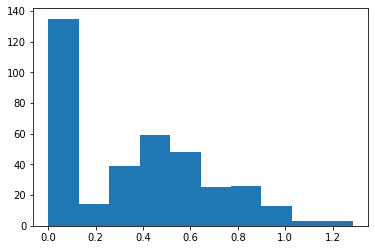

In [150]:
from matplotlib import pyplot as plt
import numpy as np
# Creating dataset
a = np.array(all_prediction_std)
# Creating histogram
fig, ax = plt.subplots()
ax.hist(a)
# Show plot
plt.show()


In [125]:
stats.percentileofscore(all_prediction_std, 0.0, 'rank')

16.84045881126173

In [122]:
1 - stats.percentileofscore(all_prediction_std, 0., 'rank')/100
 

0.8315954118873827

In [40]:
eval_df = pd.DataFrame.from_dict(eval_dist)
# write the top 10 closest EC to _top10.csv
out_filename = './eval/' + args_test_data
# _ = write_top10_choices(eval_df, out_filename)
# maximum separation results
write_max_sep_choices(eval_df, out_filename, first_grad=True, use_max_grad=False)
# get preds and true labels
pred_label = get_pred_labels(out_filename, pred_type='_maxsep')
pred_probs = get_pred_probs(out_filename, pred_type='_maxsep')
true_label, all_label = get_true_labels('./data/'+args_test_data)
pre, rec, f1, roc, acc = get_eval_metrics_new(
    pred_label, pred_probs, true_label, all_label)
print("############ Maximum separation w correct AUC ############")
print('-' * 75)
print(f'>>> total samples: {len(true_label)} | total ec {len(all_label)} |\n'
        f'precision | recall | F1 | AUC | accuracy' )
print( f'{pre:.5} , {rec:.5} , {f1:.5} , {roc:.7} , {acc:.5}')
print('-' * 75)

############ Maximum separation w correct AUC ############
---------------------------------------------------------------------------
>>> total samples: 392 | total ec 177 |
precision | recall | F1 | AUC | accuracy
0.59552 , 0.47913 , 0.49668 , 0.7389254 , 0.5102
---------------------------------------------------------------------------
